In [1]:
# importing nessecary libraries
import scipy
import sklearn
import pickle
import random
import math
import seaborn as sns
import pandas as pd
import scipy.io as sio
from scipy import stats
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score

Reducing the dimensionality of the feature vectors before performing the clustering to mitigate the impact of the behaviors duration variability and yield robust clustering. The dataset is projected onto a lower-dimensional space capturing 90% of the variance of the firing rate vectors.

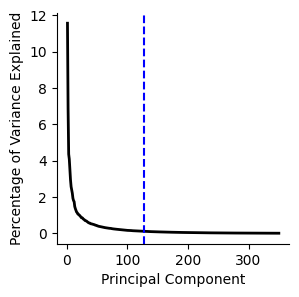

Dimension of data after PCA: (586, 128)
Explained variance by the first 128 principal components: 0.9150


In [5]:
# Load CSV data file
try:
    data = np.loadtxt('FR_clustering_LH.csv', delimiter=',')
except Exception as e:
    raise ValueError(f"Error loading data: {e}")

# Z-score normalization across rows i.e. cells 
normalized_data = stats.zscore(data, axis=1)

scaler = StandardScaler()
standardized_data = scaler.fit_transform(normalized_data)

# PCA dimensionality reduction
# Plotting the Scree Plot
fig, ax = plt.subplots(figsize=(3, 3))
pca = PCA(n_components=350)  # Refit PCA for scree plot (more components)
pca_result = pca.fit_transform(standardized_data)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_ * 100, '-', linewidth=2, color='black')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.axvline(x=128, color='blue', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


n_components = 128
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(standardized_data)

# Output the shape of reduced data and explained variance
print(f"Dimension of data after PCA: {reduced_data.shape}")
explained_variance = sum(pca.explained_variance_ratio_)
print(f"Explained variance by the first {n_components} principal components: {explained_variance:.4f}")

Next step is the performing spectral clustering using k-nearest neighbors. To find the optimal number of clusters and k-nearest neighbors, bootstarpping stability analysis should be performed.

In [ ]:
# Function to compute clusters using spectral clustering and k-nearest neighbors
def compute_Scluster(n_clusters, k_neighbors, data):
    from sklearn import cluster
    from sklearn.neighbors import kneighbors_graph
    
    # Construct k-nearest neighbors graph using cosine distance
    connectivity = kneighbors_graph(data, k_neighbors, mode='connectivity', metric='cosine')
    
    # Symmetrize the adjacency matrix
    adjacency_matrix = (1 / 2) * (connectivity + connectivity.T)
    adjacency_matrix = adjacency_matrix.toarray()

    # Performing spectral clustering 
    spectral = cluster.SpectralClustering(n_clusters=n_clusters, eigen_solver="arpack", affinity="precomputed")
    labels = spectral.fit_predict(adjacency_matrix)
    
    return labels, adjacency_matrix


# Random sampling of 90% to create 100 subsets of the data
random_indices = [random.sample(range(1, reduced_data.shape[0]), round(0.9 * reduced_data.shape[0])) for _ in range(100)]

# Initialize arrays to store Adjusted Rand Index (ARI)  and Adjusted Mutual Information (AMI)) scores
ARI = np.zeros((15, 38, 100))
AMI = np.zeros((15, 38, 100))

# for combination of number of clusters and k-nearest neighbors
for n_clusters in range(2, 17):  # Number of clusters
    for k_neighbors in range(2, 40):  # k-nearest neighbors
        cluster_labels, _ = compute_Scluster(n_clusters, k_neighbors, reduced_data)
        
        for sample_index in range(100):
            print(f"Processing cluster number {n_clusters}, kNN number {k_neighbors}, sample number {sample_index}")
            
            # Get the cluster labels for the random subset
            subset_labels, _ = compute_Scluster(n_clusters, k_neighbors, reduced_data[random_indices[sample_index], :])
            
            # Calculate ARI and AMI for the subset
            ARI[n_clusters - 2, k_neighbors - 2, sample_index] = adjusted_rand_score(cluster_labels[random_indices[sample_index]], subset_labels)
            AMI[n_clusters - 2, k_neighbors - 2, sample_index] = adjusted_mutual_info_score(cluster_labels[random_indices[sample_index]], subset_labels)

To choose the optimal combination of hyperparameters of clustering model we plot both AMI and ARI. 

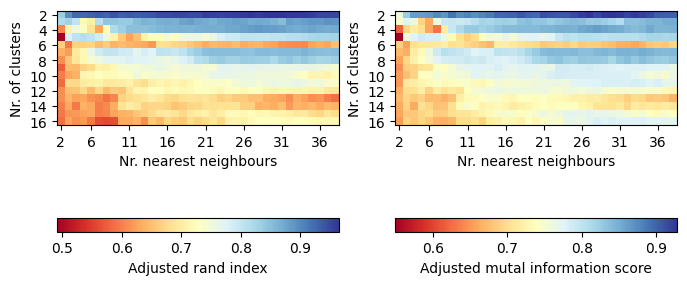

In [7]:
# storing the computed ARI and AMI in x1 and x2
x1 = ARI
x2 = AMI

# Calculate the mean across the repetitions of bootstrappings
h1 = np.mean(x1, axis=2)
h2 = np.mean(x2, axis=2)


fig, ax = plt.subplots(1, 2, figsize=(8, 8))

# Ploting ARI
im1 = ax[0].imshow(h1[0:15, 0:37], cmap='RdYlBu', interpolation='nearest') 
ax[0].set_xlabel('Nr. nearest neighbours')
ax[0].set_xticks([0, 4, 9, 14, 19, 24, 29, 34])
ax[0].set_xticklabels(['2', '6', '11', '16', '21', '26', '31', '36'])
ax[0].set_ylabel('Nr. of clusters')
ax[0].set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
ax[0].set_yticklabels(['2', '4', '6', '8', '10', '12', '14', '16'])
plt.colorbar(im1, ax=ax[0], orientation='horizontal', label='Adjusted rand index')


# Ploting AMI
im2 = ax[1].imshow(h2[0:15, 0:37], cmap='RdYlBu', interpolation='nearest') 
ax[1].set_xlabel('Nr. nearest neighbours')
ax[1].set_xticks([0, 4, 9, 14, 19, 24, 29, 34])
ax[1].set_xticklabels(['2', '6', '11', '16', '21', '26', '31', '36'])
ax[1].set_ylabel('Nr. of clusters')
ax[1].set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
ax[1].set_yticklabels(['2', '4', '6', '8', '10', '12', '14', '16'])
plt.colorbar(im2, ax=ax[1], orientation='horizontal', label='Adjusted mutual information score')


plt.tight_layout()
plt.show()

Optimal hyperparameters (number of clusters and k-NN) are determined as the maximal mean and mean adjusted for variance (mean/standard deviation ratio) of ARI and AMI across bootstrapped distributions.

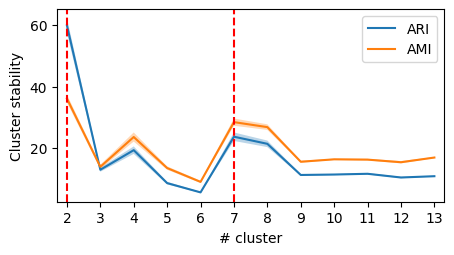

In [10]:
fig = plt.figure(figsize=(5, 2.5))

# Normalize mean ARI adjusted for variance (mean/standard deviation ratio)
h1 = np.mean(x1, axis=2) / np.std(x1, axis=2)
plt.plot(range(0, 12), np.mean(h1[0:12, 0:38], axis=1), label='ARI')
plt.fill_between(range(0, 12), 
                 np.mean(h1[0:12, 0:38], axis=1) - scipy.stats.sem(h1[0:12, 0:38], axis=1),
                 np.mean(h1[0:12, 0:38], axis=1) + scipy.stats.sem(h1[0:12, 0:38], axis=1), 
                 alpha=0.3)


# Normalize mean AMI adjusted for variance (mean/standard deviation ratio)
h2 = np.mean(x2, axis=2) / np.std(x2, axis=2)
plt.plot(range(0, 12), np.mean(h2[0:12, 0:38], axis=1), label='AMI')
plt.fill_between(range(0, 12), 
                 np.mean(h2[0:12, 0:38], axis=1) - scipy.stats.sem(h2[0:12, 0:38], axis=1),
                 np.mean(h2[0:12, 0:38], axis=1) + scipy.stats.sem(h2[0:12, 0:38], axis=1), 
                 alpha=0.3)


# Add vertical lines for points with highest stability (here cluster numbers 2 and 7)
plt.axvline(x=0, linestyle='--', color='r') # cluster numbers 2
plt.axvline(x=5, linestyle='--', color='r') # cluster numbers 7

plt.xlabel('# cluster')
plt.ylabel('Cluster stability')
plt.xticks(range(12), ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])

# x-axis limits for better visualization
plt.xlim(-0.3, 11.3)

plt.tight_layout()
plt.show()

To further ensure robust clustering quality, we calculated silhouette scores, which measure the similarity of individual data samples to their assigned clusters compared with other clusters using intracluster and nearest-cluster distances, across 100 clustering iterations. Neurons consistently assigned to their respective clusters, i.e., with a silhouette score above 0 for at least 95 of the iterations, were considered for further analysis.

In [14]:
# Initialize lists to store adjacency matrices, cluster labels, and silhouette scores
adjacency_matrices = [None] * 100
cluster_labels = [None] * 100
silhouette_values = np.array([])  
silhouette_averages = np.array([])

# Compute silhouette scores for each sample 100 times
for i in range(100):
    adj, model_labels = compute_Scluster(7, 21, reduced_data)
    
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(reduced_data, model_labels, metric='cosine')
    sample_silhouette_values = silhouette_samples(reduced_data, model_labels, metric='cosine')
    
    # Stack silhouette values and average scores
    silhouette_values = np.vstack([silhouette_values, sample_silhouette_values.reshape(1, -1)]) if silhouette_values.size else sample_silhouette_values.reshape(1, -1)
    cluster_labels[i] = model_labels
    adjacency_matrices[i] = adj
    silhouette_averages = np.vstack([silhouette_averages, silhouette_avg]) if silhouette_averages.size else silhouette_avg

# Identify cells reliably assigned to the correct clusters (95% threshold)
threshold_percentage = 95  
min_positive_count = int(threshold_percentage / 100 * silhouette_values.shape[1])
non_noise_cells = []

# Count positive silhouette values for each cell
for i, row in enumerate(silhouette_values):
    count_positive = np.sum(row > 0)
    if count_positive >= min_positive_count:
        non_noise_cells.append(i)

print("Nr. of good cells: ", len(non_noise_cells))

# Store adjacency matrix and cluster labels for non-noisy cells for further analysis
index = np.argmax(silhouette_averages)
adjacency_matrix = adjacency_matrices[index]
labels_for_non_noise = cluster_labels[index][non_noise_cells]
adjacency_non_noise = adjacency_matrix[non_noise_cells, :][:, non_noise_cells]

data_dict={'adj':adjacency_matrix, 'Non_noise_cells':non_noise_cells, 'C':labels_for_non_noise}
with open('filtered_cluster.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

Nr. of good cells:  549


While stability analysis evaluates the robustness of clustering, it does not reveal its quality, i.e., the similarity of data within clusters and their dissimilarity between clusters. For instance, low intracluster correlations may be an indication of subclusters within a cluster and the need for further segmentation. Clustering quality was estimated by Pearson’s correlations between the first five principal components of firing rate vectors for cells from the same or different clusters.

Corr coeff; t-statistic: 15.92, p-value: 0.000004, degrees of freedom: 6
Corr ratio; t-statistic: 6.24, p-value: 0.000783, degrees of freedom: 6


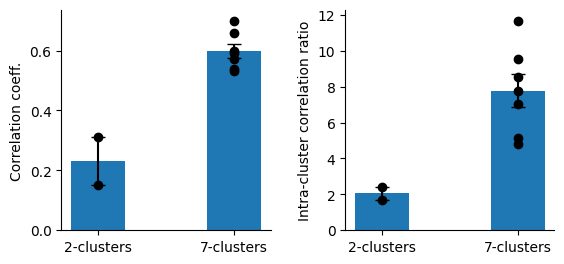

Nr. of cells in cluster 1 :  72
Nr. of cells in cluster 2 :  68
Nr. of cells in cluster 3 :  95
Nr. of cells in cluster 4 :  64
Nr. of cells in cluster 5 :  60
Nr. of cells in cluster 6 :  67
Nr. of cells in cluster 7 :  123


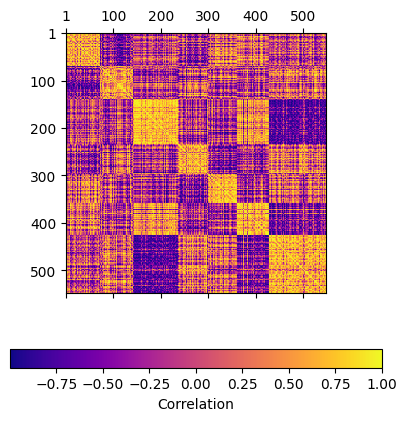

In [52]:
# Load clean cells' firing rate feature vector data from the pickle file
with open('filtered_cluster.pkl', 'rb') as f:
    dt = pickle.load(f)    
cluster_labels_7 = dt['C']
adjacency_matrix_7 = dt['adj']
non_noise_cells = dt['Non_noise_cells']

# Initialize the adjacency matrix for non-noisy cells
r_7 = np.zeros((len(non_noise_cells), len(non_noise_cells)))
adjacency_matrix_7 = np.ceil(adjacency_matrix_7)

# Sort the cells based on their clusters for clu-number=7
idxx_7 = [None] * 7
for i in range(7):
    idx = np.where(cluster_labels_7 == i)[0]  # Get indices of cells in cluster i
    idxx_7[i] = idx


# Flatten the cluster indices for reordering
idxxx = list(itertools.chain(*idxx_7))
ixgrid_7 = np.ix_(idxxx, idxxx)    
r_7 = adjacency_matrix[ixgrid_7]

# Load firing rate feature vectors of cells and perform PCA
F = np.loadtxt('FR_clustering_LH.csv', delimiter=',')
X = stats.zscore(F, axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X)

# Filter to get the feature vectors of non-noise cells
X_filtered = X_reduced[non_noise_cells, :]

# Correlation matrix for clu-number=7
correlation_matrix = np.corrcoef(X_filtered)
ordered_correlation_matrix = np.zeros_like(correlation_matrix)

ordered_indices = []
for indices in idxx_7:
    ordered_indices.extend(indices)

# Reorder the correlation matrix
ordered_correlation_matrix = correlation_matrix[ordered_indices][:, ordered_indices]
cl_7 = ordered_correlation_matrix



### Perform the similar analysis for clu-number=2

# First compute the clustering 
[adjacency_matrix_2, model_labels_2]=compute_Scluster(2,21,X_reduced) 
r_2=np.zeros((len(model_labels_2), len(model_labels_2)))
adjacency_matrix_2=np.ceil(adjacency_matrix_2)

# Sort cells based on clusters
idxx_2 = [None] * 2
for i in range(2):
    idx = np.where(model_labels_2 == i)[0]
    idxx_2[i] = idx

# Flatten indices for the second cluster
idxxx = list(itertools.chain(*idxx_2))
ixgrid_2 = np.ix_(idxxx, idxxx)    
r_2 = adjacency_matrix[ixgrid_2] 

# Correlation matrix for the second clustering
correlation_matrix = np.corrcoef(X_reduced)
ordered_correlation_matrix = np.zeros_like(correlation_matrix)

ordered_indices = []
for indices in idxx_2:
    ordered_indices.extend(indices)

# Reorder the correlation matrix
ordered_correlation_matrix = correlation_matrix[ordered_indices][:, ordered_indices]
cl_2 = ordered_correlation_matrix


cluster_lengths = [len(idx) for idx in idxx_7]
cumulative_lengths = np.cumsum(cluster_lengths)
e2 = np.zeros((len(cluster_lengths), 2), dtype=int)

# Assign the start and end points for each cluster for clu-number=2 (e1) and clu-number=7 (e2)
e2[:, 0] = np.concatenate(([0], cumulative_lengths[:-1]))
e2[:, 1] = cumulative_lengths
e1 = np.array([[0, len(idxx_2[0])],
                [len(idxx_2[0]), len(model_labels_2)]])

def calculate_mean_and_ratio(cl, e):
    y_1 = []
    y_2 = []
    for i in range(len(e)):
        temp = cl[e[i, 0]:e[i, 1], e[i, 0]:e[i, 1]]
        temp2 = np.delete(cl[e[i, 0]:e[i, 1], :], slice(e[i, 0], e[i, 1]), axis=1)

        upt = np.triu(np.ones(temp.shape), k=1)
        temp[~upt.astype(bool)] = np.nan
        y_1.append(np.nanmean(temp))
        y_2.append((np.nanmean(temp) - np.nanmean(temp2)) / abs(np.nanmean(temp2)))
    return y_1, y_2

# Calculate intra-cluster correlation coeff. and ratio for cl_2 and cl_7
y1_1, y1_2 = calculate_mean_and_ratio(cl1, e1)  # Two clusters
y2_1, y2_2 = calculate_mean_and_ratio(cl2, e2)  # Seven clusters

# Statistics
t_stat, p_val = stats.ttest_1samp(y2_1, popmean=np.mean(y1_1))
print(f"Corr coeff; t-statistic: {t_stat:.2f}, p-value: {p_val:.6f}, degrees of freedom: {len(y2_1) - 1}")
t_stat, p_val = stats.ttest_1samp(y2_2, popmean=np.mean(y1_2))
print(f"Corr ratio; t-statistic: {t_stat:.2f}, p-value: {p_val:.6f}, degrees of freedom: {len(y2_2) - 1}")




fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Plot for correlation coefficient
x = [np.mean(y1_1), np.mean(y2_1)]
err = [scipy.stats.sem(y1_1), scipy.stats.sem(y2_1)]
ax[0].bar(np.arange(2), x, yerr=err, capsize=5, width=0.4)
ax[0].set_xticks(np.arange(2))
ax[0].set_xticklabels(['2-clusters', '7-clusters'])
ax[0].set_ylabel('Correlation coefficient')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Scatter plot for individual data points
for i, y_data in enumerate([y1_1, y2_1]):
    xpos = np.ones(len(y_data)) * i
    ax[0].scatter(xpos, y_data, color='k', zorder=5)

# Plot for intra-cluster correlation ratio and scatter plot for individual data points
x = [np.mean(y1_2), np.mean(y2_2)]
err = [scipy.stats.sem(y1_2), scipy.stats.sem(y2_2)]
ax[1].bar(np.arange(2), x, yerr=err, capsize=5, width=0.4)
ax[1].set_xticks(np.arange(2))
ax[1].set_xticklabels(['2-clusters', '7-clusters'])
ax[1].set_ylabel('Intra-cluster correlation ratio')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

for i, y_data in enumerate([y1_2, y2_2]):
    xpos = np.ones(len(y_data)) * i
    ax[1].scatter(xpos, y_data, color='k', zorder=5)

fig.tight_layout(pad=2)
plt.show()

# Print number of cells in each cluster for clu-number=7
for i in range(7):
    print("Number of cells in cluster", i + 1, ": ", len(idxx[i]))


# Plot Pearson's correlations coefficients of cells for optimal clu number i.e. clu-number=7
m=plt.matshow(cl_7, cmap='plasma')
cbar=plt.colorbar(m, orientation='horizontal', label='Correlation') 

x_ticks = np.arange(0, cl_7.shape[1], 100)  
y_ticks = np.arange(0, cl_7.shape[0], 100)  
x_labels = [(i // 100) + 1 for i in x_ticks]  
y_labels = [(i // 100) + 1 for i in y_ticks]  
plt.xticks(ticks=x_ticks, labels=[1] + [i * 100 for i in range(1, len(x_labels))])  
plt.yticks(ticks=y_ticks, labels=[1] + [i * 100 for i in range(1, len(y_labels))])
plt.show()

Then the relation between the clusters and the firig rate dynamics of cells can be investigated to reveal the presence of any potential behavioral states pattern.

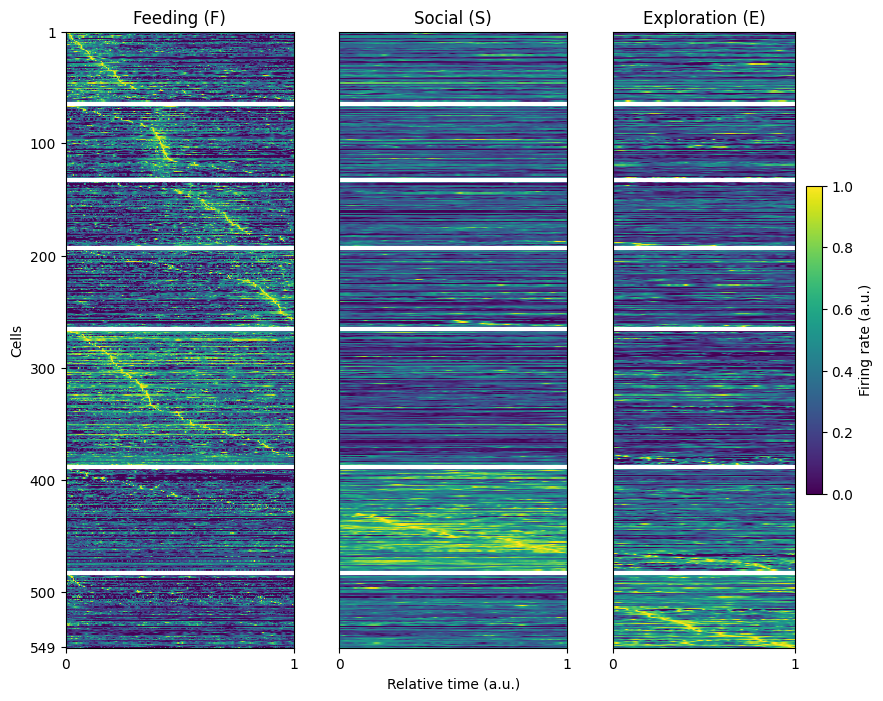

In [57]:
# Ploting the firing rate dynamics of cells in each clusters during all the three behaviors
F = np.loadtxt('FR_clustering_LH.csv', delimiter=',')


fig1, ax = plt.subplots(1, 3, figsize=(10, 8))

# Smooth the firing rate vectors and normalize
y_g1d = ndimage.gaussian_filter1d(F[non_noise_cells, :], 10)  
X_n = sklearn.preprocessing.minmax_scale(y_g1d, feature_range=(0, 1), axis=1)  

# Prepare the data for plotting
ht = np.hstack([X_n, np.argmax(X_n, axis=1).reshape(-1, 1)])  # Add index of max as last column
X_sort = np.empty((0, ht.shape[1]))  # Initialize an empty array

# Sort the cells based on their clusters
for i in range(len(idxx_7)):
    temp1 = ht[idxx_7[i], :]
    temp = temp1[temp1[:, -1].argsort(), :-1]  # Sort by max column
    X_sort = np.vstack([X_sort, temp]) if X_sort.size else temp

# Plotting for Feeding
ind = range(0, 13914)
ax[0].matshow(X_sort[:, ind], aspect="auto")
ax[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
ax[0].set_xticks([0, len(ind)])
ax[0].set_xticklabels(['0', '1'])
ax[0].set_yticks([0, 99, 199, 299, 399, 499, 548])
ax[0].set_yticklabels(['1', '100', '200', '300', '400', '500', '549'])
ax[0].set_ylabel('Cells')
ax[0].set_title('Feeding (F)')


# Plotting for Social
ind = range(13914, 13914 + 1774)
ax[1].matshow(X_sort[:, ind], aspect="auto")
ax[1].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
ax[1].set_xticks([0, len(ind)])
ax[1].set_xticklabels(['0', '1'])
ax[1].set_yticks([])
ax[1].set_title('Social (S)')


# Plotting for Exploration
ind = range(1774 + 13914, 17727)
m = ax[2].matshow(X_sort[:, ind], aspect="auto")
ax[2].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
ax[2].set_xticks([0, len(ind)])
ax[2].set_xticklabels(['0', '1'])
ax[2].set_yticks([])
ax[2].set_title('Exploration (E)')
plt.colorbar(m, label='Firing rate (a.u.)', shrink=0.5)

# Add horizontal lines to separate clusters
for j in range(3):
    k = 0
    for i in range(len(idxx_7) - 1):
        ax[j].axhline(y=len(idxx_7[i]) + k, color='w', lw=3)
        k += len(idxx_7[i])

ax[1].set_xlabel('Relative time (a.u.)')
plt.show()


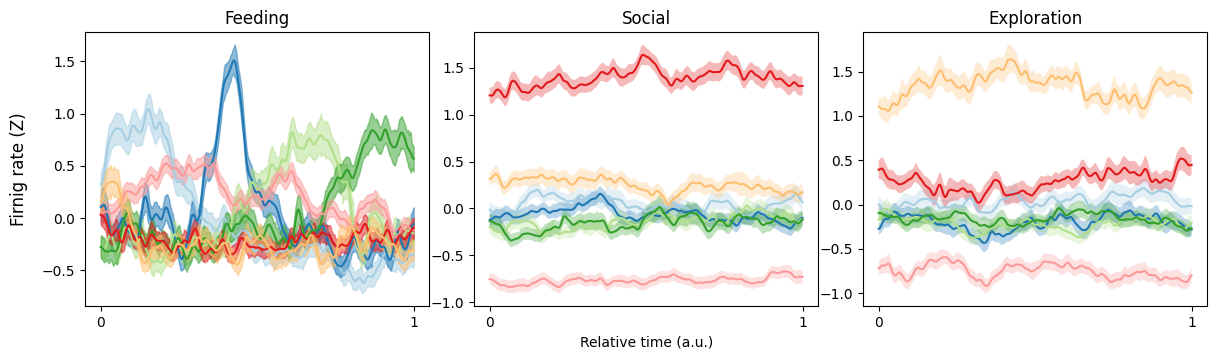

In [28]:
# Ploting the average firing rate vectors of clusters across cells 

fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(12,3))

colors=[]
for i in sns.color_palette("Paired"):
    colors.append(i)   


X=X_filtered[non_noise_cells,:]


i=0
while i<len(idxx_7):
        
        
    y_g1d = ndimage.gaussian_filter1d(X[idxx_7[i],0:13914], 100) 
    ax[0].plot(np.mean(y_g1d,0), color=colors[i])
    err=stats.sem(X[idxx_7[i],0:13914],0)
    y=np.mean(y_g1d,0)
    ax[0].fill_between(range(0,13914), y-err, y+err, alpha=0.5, color=colors[i])
    ax[0].set_ylabel('Firnig rate (Z)', rotation='vertical', labelpad=10, fontsize=12)
    ax[0].set_xticks([0, 13913])
    ax[0].set_xticklabels(['0','1'])
    
    
   
    y_g1d = ndimage.gaussian_filter1d(X[idxx_7[i],13914:13914+1774], 10)
    ax[1].plot(np.mean(y_g1d,0), color=colors[i])
    err=stats.sem(X[idxx_7[i],13914:13914+1774],0)
    y=np.mean(y_g1d,0)
    ax[1].fill_between(range(0,1774), y-err, y+err, alpha=0.3, facecolor=colors[i])
    ax[1].set_xticks([0, 1773])
    ax[1].set_xticklabels(['0','1'])
    
    
    
    y_g1d = ndimage.gaussian_filter1d(X[idxx_7[i],13914+1774:], 10)
    ax[2].plot(np.mean(y_g1d,0), color=colors[i])
    err=stats.sem(X[idxx_7[i],13914+1774:],0)
    y=np.mean(y_g1d,0)
    ax[2].fill_between(range(0,2039), y-err, y+err, alpha=0.3, facecolor=colors[i])
    ax[2].set_xticks([0, 2038])
    ax[2].set_xticklabels(['0','1'])
    
    
    i+=1
    
fig.tight_layout(pad=0.1)
    
ax[1].set_xlabel('Relative time (a.u.)') 
ax[0].set_title('Feeding')
ax[1].set_title('Social')
ax[2].set_title('Exploration')

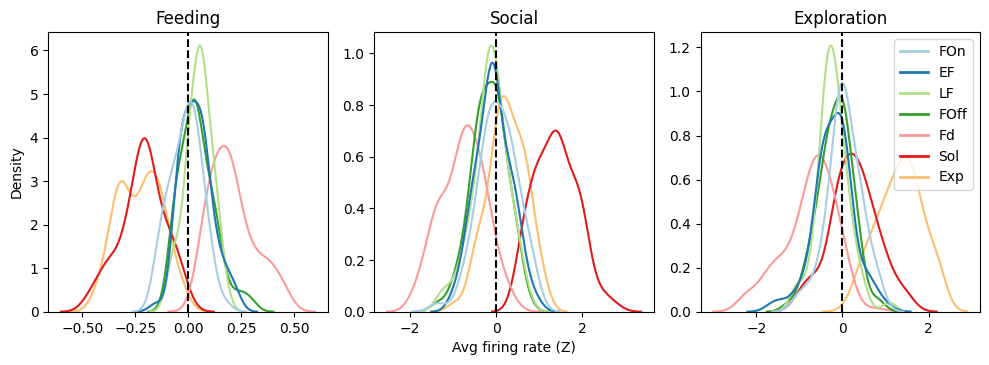

In [29]:
# Plotting kernel density estimations of the average firing rate of each population during behaviors

FR=np.empty((len(non_noise_cells),3))
FR[:,0]=np.mean(X[:,0:13914],1)
FR[:,1]=np.mean(X[:,13914:13914+1774],1)
FR[:,2]=np.mean(X[:,13914+1774:],1)

p=pd.DataFrame(data=FR)
cols=['F', 'S', 'O', 'Cluster id']
g=np.empty((len(non_noise_cells),))
g[:]=np.nan
for i in range(0,len(idxx_7)):
    g[idxx_7[i]]=int(i+1)
    
FR1=np.hstack([FR,g.reshape(-1,1)])
p1=pd.DataFrame(FR1, columns=cols)

colors=[]
for i in sns.color_palette("Paired"):
    colors.append(i)   
clusters=range(1,8)

fig, ax=plt.subplots(1,3, figsize=(10,10))

sns.kdeplot(ax=ax[0], data=p1, x="F", hue="Cluster id", palette='Paired', fill=False, common_norm=False, legend=False)
sns.kdeplot(ax=ax[1], data=p1, x="S", hue="Cluster id", palette='Paired', fill=False, common_norm=False, legend=False) 
sns.kdeplot(ax=ax[2], data=p1, x="O", hue="Cluster id", palette='Paired', fill=False, common_norm=False)

legend_labels = ["FOn", "EF", "LF", "FOff", "Fd", "Sol", "Exp"]  
legend_handles = [plt.Line2D([0], [0], color=color, lw=2) for color in colors]
ax[2].legend(legend_handles, legend_labels, loc='upper right')

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)

ax[0].set_xlabel("")
ax[1].set_xlabel("Avg firing rate (Z)")
ax[2].set_xlabel("")

ax[0].set_title('Feeding')
ax[1].set_title('Social')
ax[2].set_title('Exploration')
            
plt.setp(ax[1], ylabel='')
plt.setp(ax[2], ylabel='')  

ax[0].axvline(x=0, linestyle='--', color='k')
ax[1].axvline(x=0, linestyle='--', color='k')
ax[2].axvline(x=0, linestyle='--', color='k')

plt.tight_layout()

(549, 4)


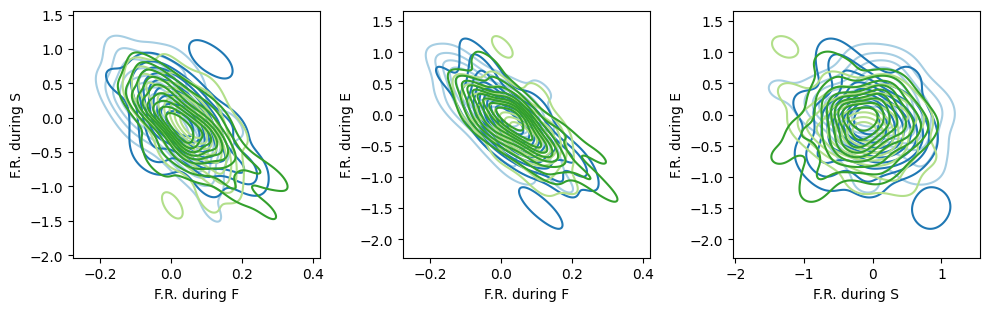

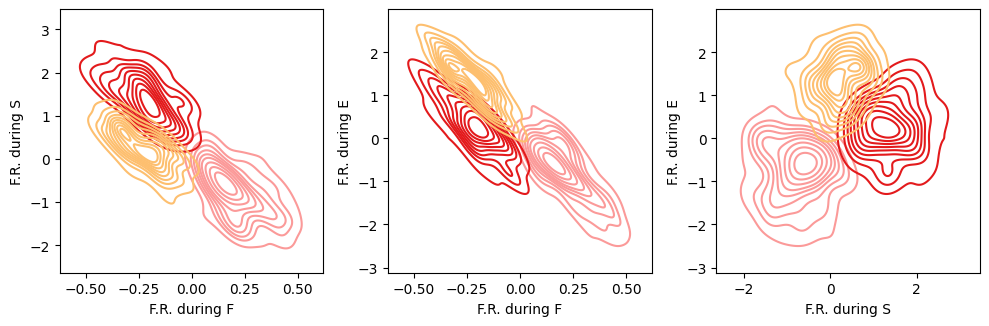

In [30]:
# Plotting probability density estimations of pearson correlation coefficients of mean firing rate between
# the three behaviors for feeding phase (left plots) and other behavior-specific population

# Feeding phase clusters
num_Feed=264
FR=np.empty((num_Feed,3))
array1 = np.array(idxx_7[0])
array2 = np.array(idxx_7[1])
array3 = np.array(idxx_7[2])
array4 = np.array(idxx_7[3])
concatenated_array = np.concatenate([array1, array2, array3, array4])
liss = list(concatenated_array)
FR[:,0]=np.mean(X[liss,0:13914],1)
FR[:,1]=np.mean(X[liss,13914:13914+1774],1)
FR[:,2]=np.mean(X[liss,13914+1774:],1)

p=pd.DataFrame(data=FR)
cols=['F.R. during F', 'F.R. during S', 'F.R. during E', 'Cluster id']
g=np.empty((len(non_noise_cells),))
g[:]=np.nan
liss1=[0,1,2,3]
for i in range(0,len(liss1)):
    g[idxx[liss1[i]]]=int(i+1)
    
g=g[liss]    
FR1=np.hstack([FR,g.reshape(-1,1)])
p1=pd.DataFrame(FR1, columns=cols)


colors = sns.color_palette("Paired", n_colors=4)
fig, ax=plt.subplots(1,3, figsize=(10,10))
custom_palette=colors
sns.kdeplot(ax=ax[0], data=p1, x="F.R. during F", y="F.R. during S" ,hue="Cluster id", palette=custom_palette, fill=False, common_norm=False, legend=False)
sns.kdeplot(ax=ax[1], data=p1, x="F.R. during F", y="F.R. during E" ,hue="Cluster id", palette=custom_palette, fill=False, common_norm=False, legend=False)
sns.kdeplot(ax=ax[2], data=p1, x="F.R. during S", y="F.R. during E" ,hue="Cluster id", palette=custom_palette, fill=False, common_norm=False, legend=False)

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)
plt.tight_layout()


# Whole behavior clusters
FR=np.empty((len(non_noise_cells)-num_Feed,3))
array1 = np.array(idxx_7[4])
array2 = np.array(idxx_7[5])
array3 = np.array(idxx_7[6])
concatenated_array = np.concatenate([array1, array2, array3])
liss = list(concatenated_array)
FR[:,0]=np.mean(X[liss,0:13914],1)
FR[:,1]=np.mean(X[liss,13914:13914+1774],1)
FR[:,2]=np.mean(X[liss,13914+1774:],1)

p=pd.DataFrame(data=FR)
cols=['F.R. during F', 'F.R. during S', 'F.R. during E', 'Cluster id']
liss1=[4,5,6]
g=np.empty((len(non_noise_cells),))
g[:]=np.nan
for i in range(0,len(liss1)):
    g[idxx[liss1[i]]]=int(liss1[i]+1)
    
g=g[liss]    
FR1=np.hstack([FR,g.reshape(-1,1)]) 
p1=pd.DataFrame(FR1, columns=cols)


colors = sns.color_palette("Paired", n_colors=7)
fig, ax=plt.subplots(1,3, figsize=(10,10))
custom_palette=colors[4:]
sns.kdeplot(ax=ax[0], data=p1, x="F.R. during F", y="F.R. during S" ,hue="Cluster id", palette=custom_palette, fill=False, common_norm=False, legend=False) 
sns.kdeplot(ax=ax[1], data=p1, x="F.R. during F", y="F.R. during E" ,hue="Cluster id", palette=custom_palette, fill=False, common_norm=False, legend=False) 
sns.kdeplot(ax=ax[2], data=p1, x="F.R. during S", y="F.R. during E" ,hue="Cluster id", palette=custom_palette, fill=False, common_norm=False, legend=False)

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)
plt.tight_layout()